In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import json
from MathFunctions import *
from DoublePendulumRefactor import DoublePendulum, DoublePendulumExplorer

In [2]:
# Declare variables & constants
t = sp.Symbol("t")
l1, l2, m1, m2, M1, M2, g = sp.symbols('l1 l2 m1 m2 M1 M2 g', real=True, positive=True)

# Declare functions
theta1 = sp.Function('theta1')(t)
theta2 = sp.Function('theta2')(t)
omega1 = sp.Function('omega1')(t)
omega2 = sp.Function('omega2')(t)

In [3]:
# Define parameters
params = {
    m1: 1,    # mass1
    m2: 1,    # mass2
    M1: 1,    # compound mass1
    M2: 1,    # compound mass2
    l1: 1,    # length1
    l2: 1,    # length2
    g : 9.81  # acceleration due to gravity
}

# using (time end - time start) * 200
# Is this enough/too much??
time = [0, 120, 48000]

In [4]:
# Instantiate DoublePendulumExplorer
simple_explorer = DoublePendulumExplorer(params, time, 'simple')
compound_explorer = DoublePendulumExplorer(params, time, 'compound')

DoublePendulumExplorer initialized with base class.
DoublePendulumExplorer initialized with base class.


----
&nbsp;
### Creating data dictionary and testing in Pandas

#### Simple model

`Below Runtime approx: 2.5 mins`

In [5]:
simple_explorer.get_simulation_data(integrator=solve_ivp)

Simulations Complete.
Positions calculated and stored.


In [6]:
simple_dict = simple_explorer.simulation_data_dict
simple_df = pd.DataFrame(simple_dict[180])

print(simple_df.info())
simple_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   theta1  48000 non-null  float64
 1   theta2  48000 non-null  float64
 2   omega1  48000 non-null  float64
 3   omega2  48000 non-null  float64
 4   x1      48000 non-null  float64
 5   y1      48000 non-null  float64
 6   x2      48000 non-null  float64
 7   y2      48000 non-null  float64
dtypes: float64(8)
memory usage: 2.9 MB
None


,theta1,theta2,omega1,omega2,x1,y1,x2,y2
0,0.000000e+00,-1.568612,0.000000,0.000000,0.000000e+00,-1.0,-0.999998,-1.002185
1,-3.372356e-08,-1.568581,-0.000027,0.024526,-3.372356e-08,-1.0,-0.999998,-1.002215
2,-1.377129e-07,-1.568489,-0.000057,0.049051,-1.377129e-07,-1.0,-0.999997,-1.002307
3,-3.204236e-07,-1.568336,-0.000091,0.073577,-3.204236e-07,-1.0,-0.999997,-1.002461
4,-5.959482e-07,-1.568121,-0.000131,0.098102,-5.959482e-07,-1.0,-0.999997,-1.002675


----
&nbsp;
### Convert to JSON data

In [11]:
import json

# Function to convert NumPy arrays to lists
def numpy_to_list(data):
    if isinstance(data, np.ndarray):
        return data.tolist()
    elif isinstance(data, dict):
        return {k: numpy_to_list(v) for k, v in data.items()}
    else:
        return data

In [18]:
# Convert the simulation data to a JSON-serializable format
json_ready_data = {k: numpy_to_list(v) for k, v in simple_explorer.simulation_data_dict.items()}

# Serialize to a JSON file
with open('JSONdata/simulation_data.json', 'w') as jsonfile:
    json.dump(json_ready_data, jsonfile, indent=4)

TypeError: Type is not JSON serializable: numpy.ndarray

----
&nbsp;
#### Compound model

In [7]:
compound_explorer.get_simulation_data(integrator=solve_ivp)

Simulations Complete.
Positions calculated and stored.


In [9]:
compound_dict = compound_explorer.simulation_data_dict
compound_df = pd.DataFrame(compound_dict[180])

print(compound_df.info())
compound_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   theta1  48000 non-null  float64
 1   theta2  48000 non-null  float64
 2   omega1  48000 non-null  float64
 3   omega2  48000 non-null  float64
 4   x1      48000 non-null  float64
 5   y1      48000 non-null  float64
 6   x2      48000 non-null  float64
 7   y2      48000 non-null  float64
dtypes: float64(8)
memory usage: 2.9 MB
None


,theta1,theta2,omega1,omega2,x1,y1,x2,y2
0,0.000000e+00,-1.568612,0.000000,0.000000,0.000000e+00,-1.0,-0.999998,-1.002185
1,-1.732621e-08,-1.568585,-0.000014,0.021022,-1.732621e-08,-1.0,-0.999998,-1.002211
2,-7.054687e-08,-1.568507,-0.000029,0.042044,-7.054687e-08,-1.0,-0.999997,-1.002290
3,-1.633876e-07,-1.568375,-0.000046,0.063065,-1.633876e-07,-1.0,-0.999997,-1.002421
4,-3.020575e-07,-1.568191,-0.000066,0.084087,-3.020575e-07,-1.0,-0.999997,-1.002605


In [16]:
# Convert the simulation data to a JSON-serializable format
json_ready_data = {k: numpy_to_list(v) for k, v in compound_explorer.simulation_data_dict.items()}

# Serialize to a JSON file
with open('JSONdata/compound_data.json', 'w') as jsonfile:
    json.dump(json_ready_data, jsonfile, indent=4)

TypeError: Dict key must be str

----
&nbsp;
### Plot testing

In [8]:
pendulum_explorer.find_poincare_section(y_fixed=-1.75, time_interval=(0, 120), angle_interval=(0, 180))

There's a number of trajectories that "loop over" the pivot point. How do we deal with these??

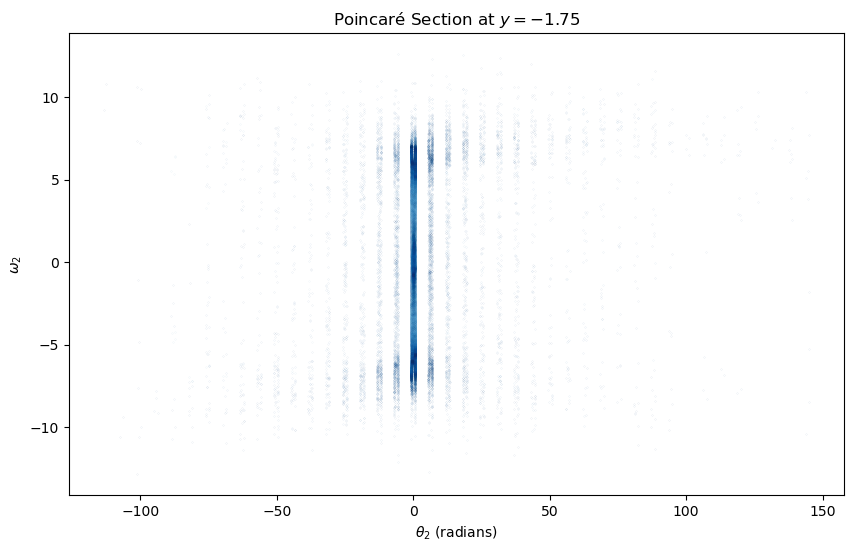

In [9]:
pendulum_explorer.plot_poincare_map()

----
&nbsp;

### Current State of `DoublePendulumExplorer`

The `DoublePendulumExplorer` class extends a `DoublePendulum` class, focusing on exploring the dynamics of a double pendulum under various initial conditions, particularly varying `theta2` angles:

- **Running Simulations**: It can execute simulations across a predefined range of initial conditions.
- **Storing Positions**: Calculates and stores the positions $(x,y)$ of both pendulums for further analysis.


### Implemented Methods

- `_run_full_simulation_and_analysis`: Manages the full cycle of running simulations, calculating positions, and organizing the data.
- `_generate_initial_conditions`, `_run_simulations`, `_calculate_and_store_positions`: These methods collectively handle the simulation process.

We have added a class attribute, `get_simulation_data()` which calls all of the above and creates a dictionary `self.simulation_data_dict` which is indexed $\theta_2 \in [-\pi, \pi, \text{step}=0.5]$ $\implies$ each index represents $0.5 ^{\circ}$

The structure is:

```python
{0: {'theta1': array([ 0.00000000e+00,  6.00715702e-20,  2.40188874e-19, ...,
         -1.42244710e+00, -1.43566953e+00, -1.44593863e+00]),
  'theta2': array([-3.14159265, -3.14159265, -3.14159265, ..., 43.92106982,
         43.9840117 , 44.04642025]),
  'omega1': array([ 0.00000000e+00,  1.20118394e-17,  2.40061350e-17, ...,
         -1.47157868e+00, -1.17370579e+00, -8.80553174e-01]),
  'omega2': array([0.00000000e+00, 2.40256435e-17, 4.80278951e-17, ...,
         6.32831315e+00, 6.26317666e+00, 6.22103776e+00]),
  'x1': array([ 0.00000000e+00,  6.00715702e-20,  2.40188874e-19, ...,
         -9.89016419e-01, -9.90884258e-01, -9.92215399e-01]),
  'y1': array([-1.        , -1.        , -1.        , ..., -0.14780569,
         -0.13471595, -0.12453354]),
  'x2': array([-1.22464680e-16, -1.22404608e-16, -1.22224491e-16, ...,
         -1.05020550e+00, -9.89169705e-01, -9.28136239e-01]),
  'y2': array([ 0.        ,  0.        ,  0.        , ..., -1.14593189,
         -1.13471448, -1.12247836])}, 1: {..., }, 2: {..., } }
```


The below are attempted implementations:

- `find_poincare_section`: Calculates the Poincaré section crossings.
- `plot_poincare_map`: Visualises the Poincaré section

Both require optimisation

### Outstanding Tasks

- **Poincaré Sections**: Identify and records the Poincaré section crossings based on a specific `y_fixed` value and within designated time and angle intervals.
- **Looping Trajectories**: Find them! that is, where $\theta_2>\pi$
- **Data Structure Optimization**: Explore database storage with MongoDB or something similar
- **Distinguishing Dense Regions**: Implementing a method to identify and visually distinguish dense regions of the Poincaré map, potentially indicating periodic orbits or other dynamic phenomena.
